In [47]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

In [48]:
print("The RQ for this quantitative analysis is: What travel motive do cyclists in the Netherlands cycle the longest duration for, and how does age influence this?")
print("The hypothesis being tested is: The relationship between travel motive and duration of a cycling trip differs significantly across age groups.")

The RQ for this quantitative analysis is: What travel motive do cyclists in the Netherlands cycle the longest duration for, and how does age influence this?
The hypothesis being tested is: The relationship between travel motive and duration of a cycling trip differs significantly across age groups.


In [49]:
# 1. CONFIGURATION
# Define all paths upfront
DATA_PATH = Path(
    r"..\csv tables\transport_per_motive.csv")
OUTPUT_FOLDER_CSV = Path(
    r"..\csv tables")
OUTPUT_FOLDER_VIS = Path(
    r"visualisations")

# Ensure output folders exist
for folder in [OUTPUT_FOLDER_CSV, OUTPUT_FOLDER_VIS]:
    folder.mkdir(parents=True, exist_ok=True)

In [50]:
# 2. DATA PROCESSING

def load_and_clean_data(file_path):
    """Load and clean the raw data"""
    data = pd.read_csv(file_path)

    # Rename columns to english
    data.rename(columns={ 
    'Geslacht': 'Gender',
    'Leeftijd': 'Age',
    'Vervoerwijzen': 'Mode of transport',
    'Reismotieven': 'Travel motives',
    'Marges': 'Margins',
    'Perioden': 'Year',
    'Ritten per persoon per dag (gemiddeld) (aantal)': 'Average trips per person per day',
    'Afgelegde afstand per rit (gemiddeld) (km)': 'Average travel distance per trip (km)',
    'Reisduur per rit (Minuten)': 'Average traveltime per tip (minutes)',
    }, inplace=True)

    # Remove unnecessary columns
    data.drop(columns=['Mode of transport'], inplace=True)
    data.drop(columns=['Year'], inplace=True)

    # Filter only 'Value' rows
    bicycle_data = data[data['Margins'] == 'Waarde'].copy()

    # Convert European number formats
    numeric_cols = [
       'Average trips per person per day',
       'Average travel distance per trip (km)',
        'Average traveltime per tip (minutes)',
    ]

    for col in numeric_cols:
        bicycle_data[col] = (
            bicycle_data[col]
            .astype(str)
            .str.replace(',', '.')
            .astype(float)
        )


    return bicycle_data

In [51]:
# One hot encoding for categorical variables
def one_hot_encode(data, column1, column2):
   encoder = OneHotEncoder(sparse_output=False, drop=['Totaal', 'Totaal']) # Initialise the encoder

   one_hot_encoded = encoder.fit_transform(data[[column1, column2]]) # Fit the encder to the data and transform it

   one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(), index=data.index) # Create a DataFrame from the encoded data

   df_encoded = pd.concat([data, one_hot_df], axis=1).dropna() # Concatenate the original DataFrame with the one-hot encoded DataFrame

   df_encoded = df_encoded.drop(columns=[column1, column2]) # Drop the original column after encoding
   return df_encoded # Return the DataFrame with the one-hot encoded columns

bicycle_data = load_and_clean_data(DATA_PATH) 
travel_one_hot = one_hot_encode(bicycle_data, 'Travel motives', 'Age') # One-hot encode the 'Travel motives' column


In [52]:
from itertools import product

travel_cols = [col for col in travel_one_hot.columns if col.startswith('Travel motives')]
age_cols = [col for col in travel_one_hot.columns if col.startswith('Age')]

# Create interaction columns
for t_col, a_col in product(travel_cols, age_cols):
    interaction_col = f'{t_col} * {a_col}'
    travel_one_hot[interaction_col] = pd.to_numeric(travel_one_hot[t_col], errors='coerce') * pd.to_numeric(travel_one_hot[a_col], errors='coerce')


In [53]:
# Check unique values for Travel motives
print("Sample Travel motives columns:\n", travel_one_hot[[col for col in travel_one_hot.columns if col.startswith('Travel motives')]].sum())

# Check unique values for Age
print("\nSample Age columns:\n", travel_one_hot[[col for col in travel_one_hot.columns if col.startswith('Age')]].sum())


Sample Travel motives columns:
 Travel motives_Onderwijs volgen, cursus, kinderopvang                         6.0
Travel motives_Overige reismotieven                                           5.0
Travel motives_Van en naar het werk                                           5.0
Travel motives_Vrije tijd                                                     5.0
Travel motives_Winkelen, boodschappen doen                                    6.0
Travel motives_Onderwijs volgen, cursus, kinderopvang * Age_12 tot 18 jaar    1.0
Travel motives_Onderwijs volgen, cursus, kinderopvang * Age_18 tot 25 jaar    1.0
Travel motives_Onderwijs volgen, cursus, kinderopvang * Age_25 tot 30 jaar    1.0
Travel motives_Onderwijs volgen, cursus, kinderopvang * Age_30 tot 40 jaar    1.0
Travel motives_Onderwijs volgen, cursus, kinderopvang * Age_6 tot 12 jaar     1.0
Travel motives_Overige reismotieven * Age_12 tot 18 jaar                      1.0
Travel motives_Overige reismotieven * Age_18 tot 25 jaar          

C:\Users\31622\AppData\Local\Temp\ipykernel_28580\3414953177.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=interaction_avg.values, y=interaction_avg.index, palette='viridis')


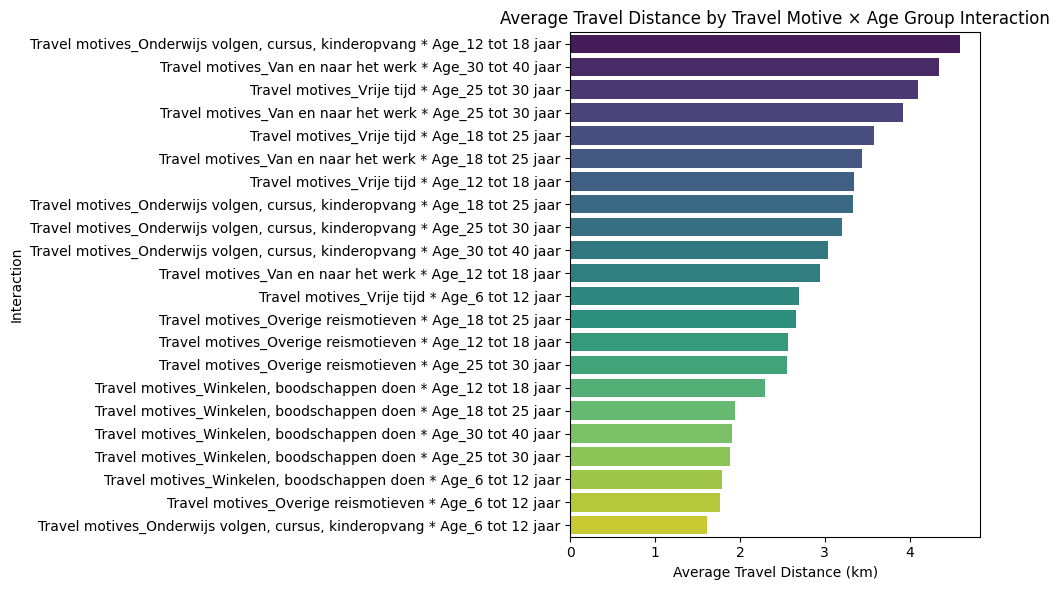

In [ ]:
# 1. Select interaction columns
interaction_cols = [col for col in travel_one_hot.columns if '*' in col]

# 2. Add average travel distance to the working DataFrame
plot_df = travel_one_hot[interaction_cols].copy()
plot_df['Avg distance'] = bicycle_data['Average travel distance per trip (km)']

# 3. Melt to long format for plotting
melted = plot_df.melt(id_vars='Avg distance', var_name='Interaction', value_name='Presence')
melted = melted[melted['Presence'] == 1]  # Keep only present interactions

# 4. Group by interaction to get average travel distance
interaction_avg = melted.groupby('Interaction')['Avg distance'].mean().sort_values(ascending=False)

# 5. Plot as bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=interaction_avg.values, y=interaction_avg.index, palette='viridis')
plt.xlabel('Average Travel Distance (km)')
plt.title('Average Travel Distance by Travel Motive × Age Group Interaction')
plt.tight_layout()
plt.show()


C:\Users\31622\AppData\Local\Temp\ipykernel_28580\4219047894.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


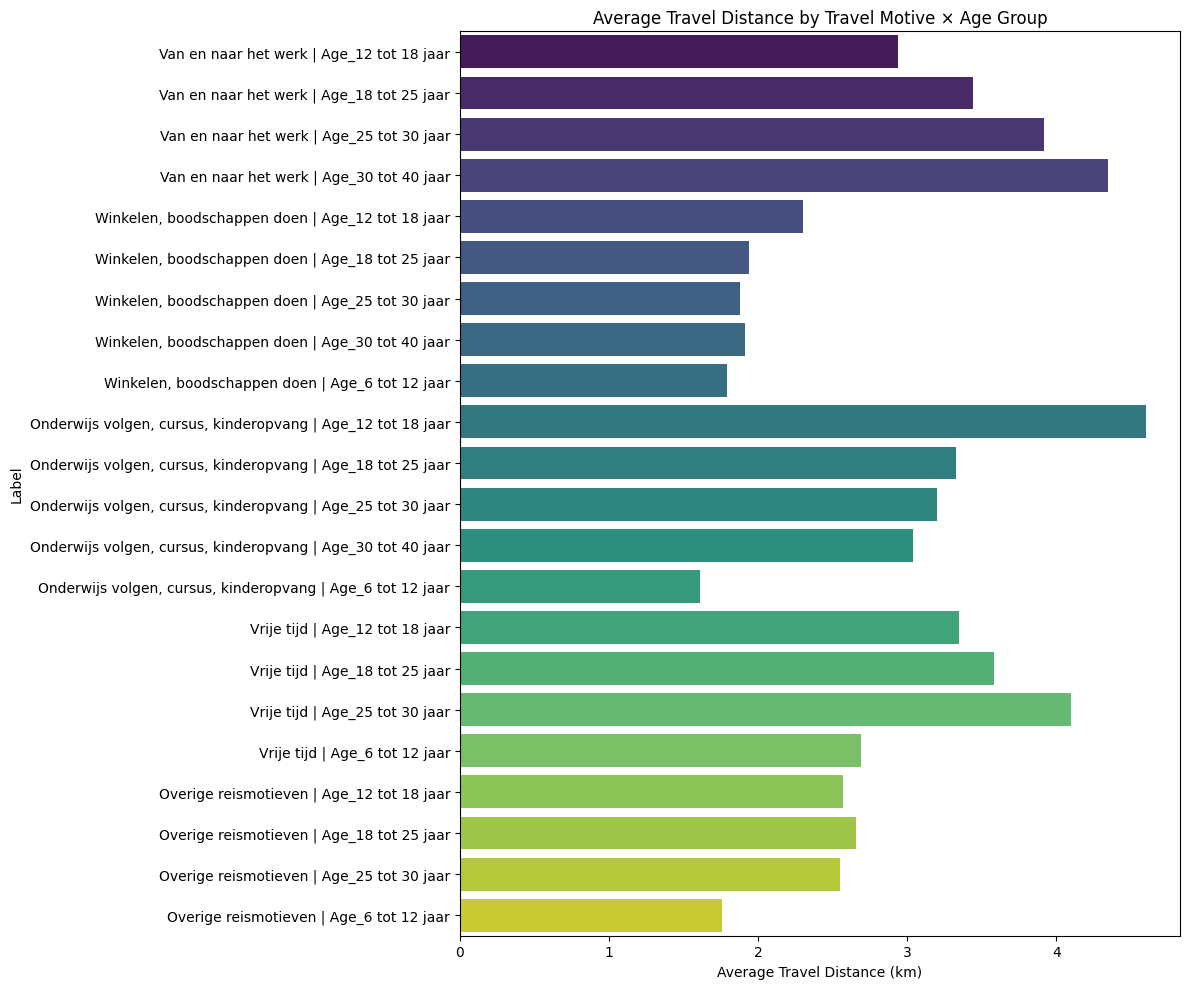

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select interaction columns
interaction_cols = [col for col in travel_one_hot.columns if '*' in col]

# 2. Add average travel distance to the working DataFrame
plot_df = travel_one_hot[interaction_cols].copy()
plot_df['Avg distance'] = bicycle_data['Average travel distance per trip (km)']

# 3. Melt to long format
melted = plot_df.melt(id_vars='Avg distance', var_name='Interaction', value_name='Presence')
melted = melted[melted['Presence'] == 1]  # Only keep actual interactions

# 4. Split Interaction column
melted[['Motive', 'Age']] = melted['Interaction'].str.split(r'\s*\*\s*', expand=True)

# 5. Calculate average distance for each interaction
grouped = melted.groupby(['Motive', 'Age'])['Avg distance'].mean().reset_index()

# 6. Define custom order
motive_order = [
    'Travel motives_Totaal',
    'Travel motives_Van en naar het werk',
    'Travel motives_Winkelen, boodschappen doen',
    'Travel motives_Onderwijs volgen, cursus, kinderopvang',
    'Travel motives_Vrije tijd',
    'Travel motives_Overige reismotieven'
]

age_order = sorted(melted['Age'].unique())  # or define manually if you want specific order

# 7. Create a combined label column for y-axis
grouped['Label'] = grouped['Motive'].str.replace('Travel motives_', '', regex=False) + ' | ' + grouped['Age']

# 8. Sort using categorical dtype
grouped['Motive'] = pd.Categorical(grouped['Motive'], categories=motive_order, ordered=True)
grouped['Age'] = pd.Categorical(grouped['Age'], categories=age_order, ordered=True)
grouped = grouped.sort_values(['Motive', 'Age'])

# 9. Plot
plt.figure(figsize=(12, 10))
sns.barplot(
    data=grouped,
    x='Avg distance',
    y='Label',
    palette='viridis'
)
plt.xlabel('Average Travel Distance (km)')
plt.title('Average Travel Distance by Travel Motive × Age Group')
plt.tight_layout()
plt.show()


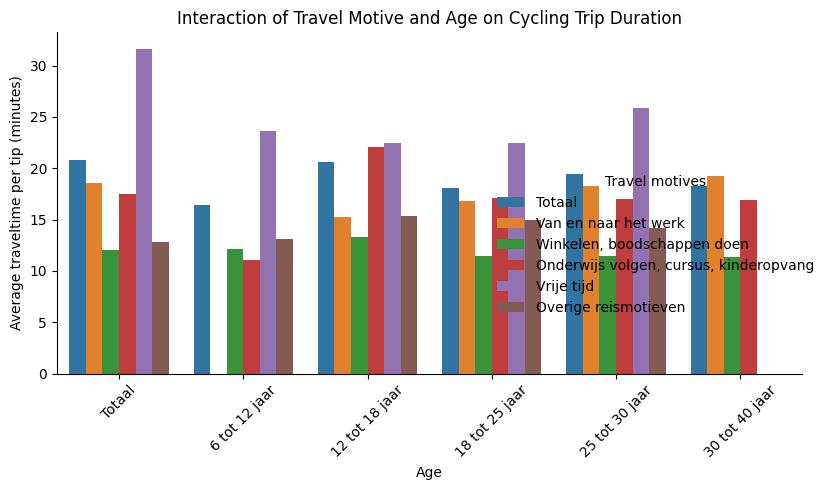

<Axes: xlabel='Age', ylabel='Average traveltime per tip (minutes)'>

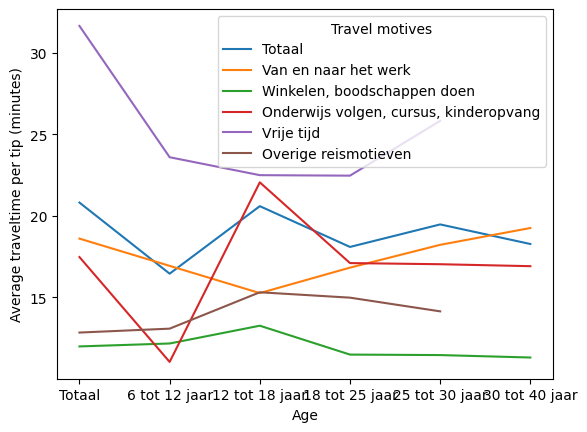

In [55]:
import seaborn as sns

sns.catplot(
    data=bicycle_data,
    kind="bar",
    x="Age",
    y="Average traveltime per tip (minutes)",
    hue="Travel motives",
)
plt.title("Interaction of Travel Motive and Age on Cycling Trip Duration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.lineplot(
    data=bicycle_data,
    x="Age",
    y="Average traveltime per tip (minutes)",
    hue="Travel motives",
)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

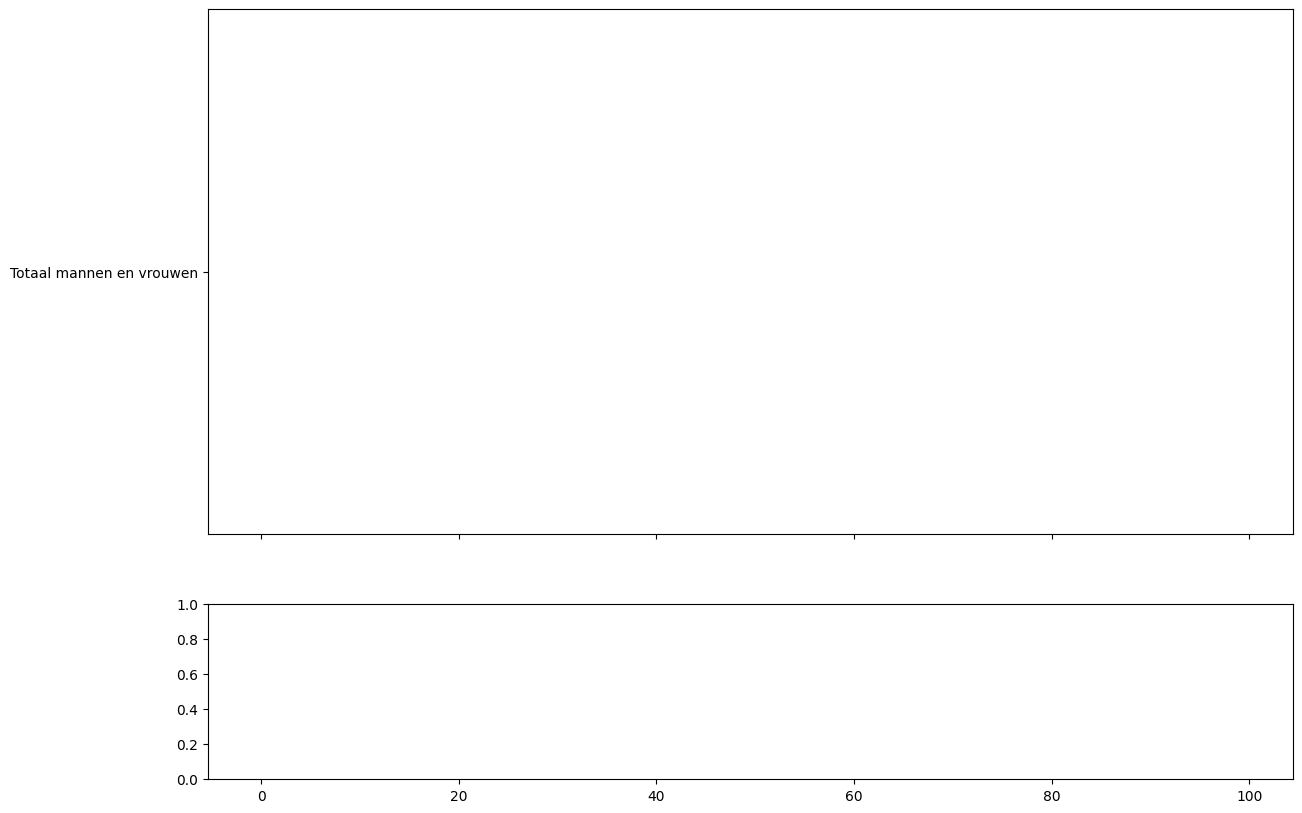

In [56]:
# Use seaborn color palette
# categories = bicycle_data.filter(like='Travel motives_')
categories = bicycle_data.columns.tolist()
palette = sns.color_palette('Set2', n_colors=len(categories))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})
# 1) Stacked bar chart on ax1
bottom = pd.Series([0]*len(bicycle_data), index=bicycle_data.index)
for i, category in enumerate(categories):
    ax1.bar(bicycle_data.index, bicycle_data[category],
            bottom=bottom, color=palette[i], label=category)
    bottom += bicycle_data[category]

ax1.set_title(
    'Interaction of Travel Motive and Age on Cycling Trip Duration')
ax1.set_ylabel('Number of Incidents')
ax1.legend(title='Type of Road Pavement',
           bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

# 2) Line chart on ax2 for trends
for i, category in enumerate(categories):
    ax2.plot(bicycle_data.index, bicycle_data[category],
             marker='o', color=palette[i], label=category)

ax2.set_title(
    'Trend of Cycling Incidents by Road Pavement Type Over Years')
ax2.set_ylabel('Number of Incidents')
ax2.set_xlabel('Year')
ax2.grid(True)


In [ ]:
import statsmodels.api as sm

X = df[travel_cols + age_cols + [f'{t} * {a}' for t, a in product(travel_cols, age_cols)]]
X = sm.add_constant(X)
y = df['Average traveltime per tip (minutes)']

model = sm.OLS(y, X).fit()
print(model.summary())


KeyError: "['Travel motives_Onderwijs volgen, cursus, kinderopvang * Age', 'Travel motives_Overige reismotieven * Age', 'Travel motives_Van en naar het werk * Age', 'Travel motives_Vrije tijd * Age', 'Travel motives_Winkelen, boodschappen doen * Age'] not in index"

In [ ]:
# 3. LINEAR REGRESSION

def linear_regression(travel__one_hot):
    # Define predictors (all one-hot columns starting with 'Travel motives_')
    X = travel__one_hot.filter(like='Travel motives_')

    # Define response variable
    y = travel__one_hot['Average travel distance per trip (km)']


    # Add constant to the model (for intercept)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()


    return model